In [59]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
from ast import literal_eval
import os

mpl.rc("font", family="serif", size=15)

In [70]:
def find_nearest(trgeff, target):
    trgeff = np.asarray(trgeff)
    idx = (np.abs(trgeff - target)).argmin()
    return int(trgeff[idx])

def fom(S,B):
    return np.sqrt(2 * ( (S+B) * np.log(1+S/B) - S) )

def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(np.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor

def rebinCalc(nBins,target):
    rebinFloat = nBins/float(target)
    allDivs = list(divisorGenerator(nBins))
    return find_nearest(allDivs, rebinFloat)

def showPotentialVar(inputFolder,data,cut):
    sigLabels = np.unique(data["sig"])
    bkgLabels = np.unique(data["bkg"])
    ROCBkg = {}
    for bkgl in bkgLabels:
        ROCBkg[bkgl] = []

    for sigl in sigLabels:
        bkgDFList = []
        for bkgl in bkgLabels:
            oneSignal = data[data["sig"]==sigl]
            oneBkgforOneSig = oneSignal[oneSignal["bkg"] == bkgl]
            obosROC = oneBkgforOneSig.sort_values("roc_auc",ascending=False)[["bkg","var","roc_auc"]]
            obosROC = obosROC.set_index(pd.Index(list(range(len(obosROC)))))
            bkgDFList.append(obosROC)
            # only consider ROC > 0.65
            ROCBkg[bkgl] += list(obosROC[obosROC["roc_auc"] > 0.65]["var"])

    jetVarDict = [
                    "Tau",
                    "Axismajor",
                    "Axisminor",
                    "Pt",
                    "Girth",
                    "SoftDropMass"
                ]
            
    rePDList = []
    plotWorthy = []
    newROCCut = 0
    for bkgl in bkgLabels:
        ROCBkg[bkgl]
        unique, counts = np.unique(ROCBkg[bkgl], return_counts=True)
        bkg = [bkgl]*len(unique)
        result = np.column_stack((bkg,unique,counts))
        rePD = pd.DataFrame(result,columns=["bkg","var","counts"]).sort_values("counts",ascending=False)
        rePD["counts"] = pd.to_numeric(rePD["counts"])
        rePD = rePD.set_index(pd.Index(list(range(len(rePD)))))
        rePDList.append(rePD)
        useful = rePD[rePD["counts"] >= 5]
        if len(useful.index) > newROCCut:
            newROCCut = len(useful.index)
        plotWorthy += list(useful["var"])
    newROC = pd.concat(rePDList,axis=1)
    varsOfInterest = []
    for var in np.unique(plotWorthy):
        jetVar = False
        for key in jetVarDict:
            if key in var:
                jetVar = True
                break
        if jetVar == False:
            varsOfInterest.append(var)
    display(newROC.head(25))
    newROC.head(newROCCut).to_csv("{}/{}/usefulVar.csv".format(inputFolder,cut))
    return varsOfInterest

def nearestCut(sigEff, cutVal, target):
    sigEff = np.asarray(sigEff)
    idx = (np.abs(sigEff - target)).argmin()
    return float(cutVal[idx])

def plotVarOfInterest(varOfInterest,data,inputFolder,cut="",sigEffTarget=0.8):
    sigLabels = np.unique(data["sig"])
    bkgLabels = np.unique(data["bkg"])
    if not os.path.exists("{}/{}".format(inputFolder,cut)):
        os.makedirs("{}/{}".format(inputFolder,cut))
    sugCuts = []
    for var in varOfInterest:
        figure, axis = plt.subplots(2, 2, figsize=(12,12))
        pos = [axis[0,0],axis[0,1],axis[1,0],axis[1,1]]
        figure.suptitle(var, fontsize=16)
        cutThs = []
        for i in range(len(bkgLabels)):
            bkgl = bkgLabels[i]
            for sigl in sigLabels:
                condition = (data["sig"] == sigl) & (data["bkg"] == bkgl) & (data["var"] == var)
                rowData = data[condition].iloc[0]
                xval = rowData["mBg_f"]
                yval = rowData["mSig_f"]
                cutval = rowData["cutSig"]
                rocScore = rowData["roc_auc"]
                rebin = rebinCalc(len(cutval),20)
                color = rowData["cSig"]
                cutDir = rowData["cutDir"]
                cutThs.append([sigl,cutDir,nearestCut(yval, cutval, sigEffTarget)])
                for j in range(len(cutval)):
                    if j%rebin == 0:
                        pos[i].text(xval[j],yval[j],"{:.2f}".format(cutval[j]),fontsize=10,color="black")
                pos[i].plot(xval,yval,color=color,linewidth=2,marker=".",label="{} ({},{})".format(sigl.replace("M-2000_",""),rocScore,cutDir.replace("cut","")))
            pos[i].plot([0,1],[0,1],linestyle=":",linewidth=2,color="black")
            pos[i].set_title(bkgl)
            pos[i].legend(fontsize=11)
            pos[i].set_ylabel(r"$\epsilon_{sig}$")
            pos[i].set_xlabel(r"$\epsilon_{bkg}$")
        cutThs = np.array(cutThs)
        # figure out the most common cut direction
        unique, counts = np.unique(cutThs[:,1], return_counts=True)
        mostCutDir = unique[np.argmax(counts)]
        # we only consider entries with the most common cut direction
        cutThs = cutThs[cutThs[:,1]==mostCutDir]
        cutThs = np.unique(cutThs,axis=0)
        # we want the loosest cut across signals, so that the signal with the worst efficiency
        # suffers as little as possible from the cut
        if mostCutDir == ">=cut":
            bestCut = np.amin(cutThs[:,2].astype(float))
        else:
            bestCut = np.amax(cutThs[:,2].astype(float))
        sugCuts.append("{} {} {}".format(var,mostCutDir.replace("cut",""),bestCut))
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.savefig("{}/{}/ROC_{}.png".format(inputFolder,cut,var))
    with open('{}/{}/suggestedCuts.txt'.format(inputFolder,cut), 'w') as f:
        f.write('\n'.join(sugCuts))
        
def bkgCheck(slabel):
    bkgLabels = ["QCD","TTJets (pow)","W+jets","Z+jets"]
    isbkg = False
    for bl in bkgLabels:
        if slabel == bl:
            isbkg = True
            break
    return isbkg

def FOMTable(inputFolder,cut):
    data = pd.read_pickle("{}/yieldValues.pkl".format(inputFolder))
    data = data.replace("Z#rightarrow#nu#nu+jets","Z+jets")
    data = data.replace("t#bar{t}","TTJets (pow)")
    yieldData = data[(data["var"]=="njetsAK8") & (data["cut"]==cut) ]
    display(yieldData)
    
    QCDYield = yieldData[yieldData["source"] == "QCD"]["yield"].iloc[0]
    TTYield = yieldData[yieldData["source"] == "TTJets (pow)"]["yield"].iloc[0]
    WYield = yieldData[yieldData["source"] == "W+jets"]["yield"].iloc[0]
    ZYield = yieldData[yieldData["source"] == "Z+jets"]["yield"].iloc[0]
    bkgYields = [QCDYield,TTYield,WYield,ZYield,np.sum([QCDYield,TTYield,WYield,ZYield])]

    fomTable = pd.DataFrame(columns=["sig","QCD","TT","W+Jets","Z+Jets","All"])
    for slabel in yieldData["source"]:
        if not bkgCheck(slabel):
            fomList = [slabel]
            sigYield = yieldData[yieldData["source"] == slabel]["yield"].iloc[0]
            fomList += list(fom(sigYield,bkgYields))
            fomTable.loc[len(fomTable.index)] = fomList
    print(cut)
    display(fomTable)
    fomTable.to_csv("{}/{}/fomTable.csv".format(inputFolder,cut))
    
def performStudy(inputFolder):
    data = pd.read_pickle("{}/allRocValues.pkl".format(inputFolder))
    data = data.replace("Z#rightarrow#nu#nu+jets","Z+jets")
    data = data.replace("t#bar{t} (pow)","TTJets (pow)")
    cuts = np.unique(data["cut"])
    for cut in cuts:
        if not os.path.exists("{}/{}".format(inputFolder,cut)):
            os.makedirs("{}/{}".format(inputFolder,cut))
        cutData = data[data["cut"] == cut]
        varsOfInterest = showPotentialVar(inputFolder,cutData,cut)
        plotVarOfInterest(varsOfInterest,cutData,inputFolder,cut=cut)
        FOMTable(inputFolder,cut)

/home/keane/anaconda3/lib/python3.7/site-packages/pandas/core/missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


bkg                var  counts           bkg                var  counts  \
0   QCD              dRj12       8  TTJets (pow)        METrHT_pt30     7.0   
1   QCD                met       8  TTJets (pow)            j1PtAK8     7.0   
2   QCD           dRj12AK8       8  TTJets (pow)                met     7.0   
3   QCD        METrHT_pt30       7  TTJets (pow)         j2Tau21AK8     7.0   
4   QCD                 nb       7  TTJets (pow)        METrST_pt30     7.0   
5   QCD          j2Tau3AK8       7  TTJets (pow)                 st     7.0   
6   QCD          j2Tau2AK8       7  TTJets (pow)        j4Axismajor     6.0   
7   QCD        METrST_pt30       7  TTJets (pow)        j4Axisminor     6.0   
8   QCD                 st       7  TTJets (pow)               j1Pt     6.0   
9   QCD            dPhij12       6  TTJets (pow)                 mT     5.0   
10  QCD         dPhij12AK8       6  TTJets (pow)        j3Axismajor     4.0   
11  QCD     j2AxisminorAK8       6  TTJets (pow)        j3Axisminor     3.0   
12  QCD              njets       5  TTJets (pow)     j2AxismajorAK8     3.0   
13  QCD         j2GirthAK8       5  TTJets (pow)              njets     3.0   
14  QCD          j2Tau1AK8       5  TTJets (pow)  j2SoftDropMassAK8     3.0   
15  QCD            j1PtAK8       5  TTJets (pow)     j1AxismajorAK8     3.0   
16  QCD        j2Axisminor       4  TTJets (pow)         j1GirthAK8     3.0   
17  QCD        j2Axismajor       4  TTJets (pow)               j2Pt     3.0   
18  QCD     j2AxismajorAK8       4  TTJets (pow)          j1Tau1AK8     3.0   
19  QCD         dPhij23AK8       4  TTJets (pow)         j2GirthAK8     3.0   
20  QCD               j1Pt       3  TTJets (pow)          j2Tau1AK8     2.0   
21  QCD               j2Pt       3  TTJets (pow)         j1Tau21AK8     2.0   
22  QCD           j2PtDAK8       3  TTJets (pow)          j1Tau2AK8     2.0   
23  QCD              j2PtD       2  TTJets (pow)  j1SoftDropMassAK8     2.0   
24  QCD  j2SoftDropMassAK8       2  TTJets (pow)     j1AxisminorAK8     2.0   

       bkg             var  counts     bkg                var  counts  
0   W+jets              st     7.0  Z+jets                 st     7.0  
1   W+jets              nb     7.0  Z+jets          j2Tau2AK8     7.0  
2   W+jets       j2Tau2AK8     7.0  Z+jets           njetsAK8     7.0  
3   W+jets       j2Tau3AK8     7.0  Z+jets        dPhiMinjMET     7.0  
4   W+jets  j2AxisminorAK8     6.0  Z+jets              njets     7.0  
5   W+jets              ht     6.0  Z+jets                 nb     7.0  
6   W+jets           njets     5.0  Z+jets               j3Pt     7.0  
7   W+jets         j1PtAK8     4.0  Z+jets          j2Tau3AK8     7.0  
8   W+jets     j2Axisminor     4.0  Z+jets     dPhiMinjMETAK8     6.0  
9   W+jets     j2Axismajor     4.0  Z+jets                 ht     6.0  
10  W+jets       j2Tau1AK8     4.0  Z+jets     j2AxisminorAK8     6.0  
11  W+jets        j2PtDAK8     4.0  Z+jets          j2Tau1AK8     5.0  
12  W+jets        dRj12AK8     4.0  Z+jets         j2GirthAK8     5.0  
13  W+jets           dRj12     4.0  Z+jets           j2PtDAK8     4.0  
14  W+jets        njetsAK8     4.0  Z+jets     j2AxismajorAK8     4.0  
15  W+jets            j1Pt     3.0  Z+jets               j4Pt     4.0  
16  W+jets  j2AxismajorAK8     3.0  Z+jets                met     3.0  
17  W+jets       j4Tau2AK8     3.0  Z+jets  j2SoftDropMassAK8     3.0  
18  W+jets      j2GirthAK8     3.0  Z+jets        METrST_pt30     3.0  
19  W+jets            j3Pt     3.0  Z+jets        METrHT_pt30     3.0  
20  W+jets       j3Tau2AK8     2.0  Z+jets        j2Axisminor     3.0  
21  W+jets           j2PtD     2.0  Z+jets            j1PtAK8     3.0  
22  W+jets  j3AxisminorAK8     2.0  Z+jets        j2Axismajor     3.0  
23  W+jets       j3Tau3AK8     2.0  Z+jets          j3Tau2AK8     2.0  
24  W+jets  j4AxisminorAK8     2.0  Z+jets            j3PtAK8     2.0

cut       var         source       yield
96   _qual_trg_st  njetsAK8         Z+jets     25437.0
97   _qual_trg_st  njetsAK8         W+jets     43045.0
98   _qual_trg_st  njetsAK8   TTJets (pow)    115574.0
99   _qual_trg_st  njetsAK8            QCD  15783518.0
100  _qual_trg_st  njetsAK8       mMed 600     26066.0
101  _qual_trg_st  njetsAK8       baseline       413.0
102  _qual_trg_st  njetsAK8    M-2000_mD-1       834.0
103  _qual_trg_st  njetsAK8  M-2000_mD-100       395.0
104  _qual_trg_st  njetsAK8   M-2000_r-0p1       399.0
105  _qual_trg_st  njetsAK8   M-2000_r-0p7       322.0
106  _qual_trg_st  njetsAK8   M-2000_a-low       465.0
107  _qual_trg_st  njetsAK8  M-2000_a-high       438.0

_qual_trg_st


sig       QCD         TT      W+Jets      Z+Jets       All
0       mMed 600  6.559232  74.032488  115.376211  143.290138  6.521340
1       baseline  0.103955   1.214120    1.987451    2.582547  0.103354
2    M-2000_mD-1  0.209923   2.450275    4.006925    5.200983  0.208710
3  M-2000_mD-100  0.099425   1.161234    1.900962    2.470279  0.098850
4   M-2000_r-0p1  0.100431   1.172987    1.920183    2.495229  0.099851
5   M-2000_r-0p7  0.081050   0.946726    1.550081    2.014701  0.080581
6   M-2000_a-low  0.117044   1.366885    2.237239    2.906731  0.116367
7  M-2000_a-high  0.110248   1.287568    2.107554    2.738432  0.109611

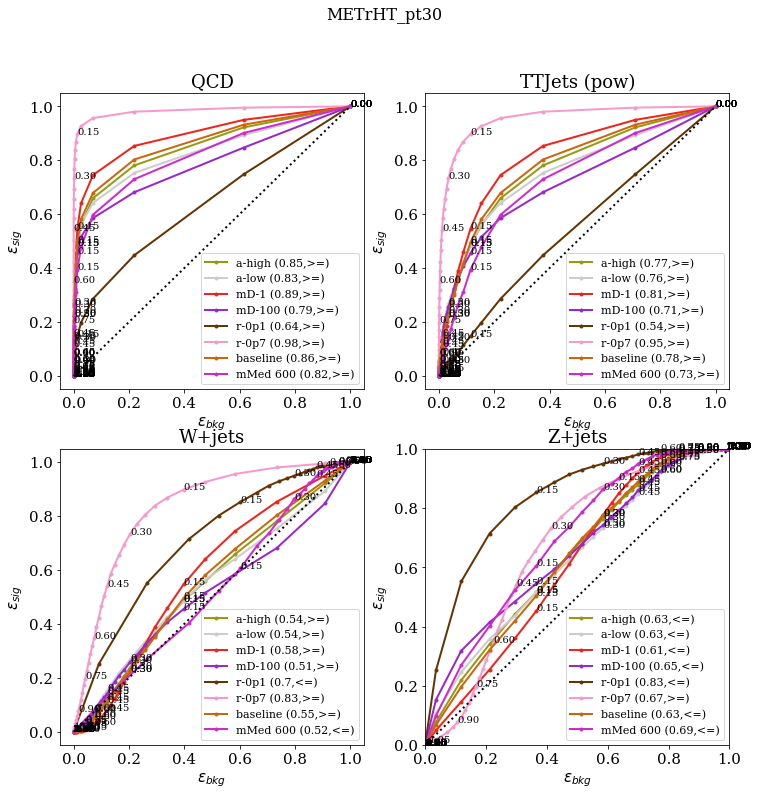

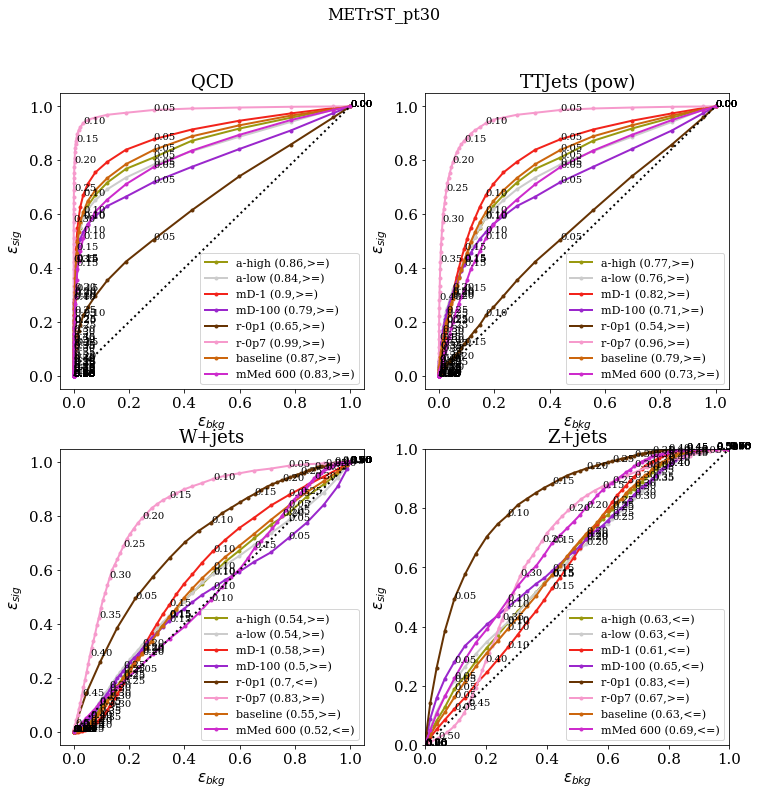

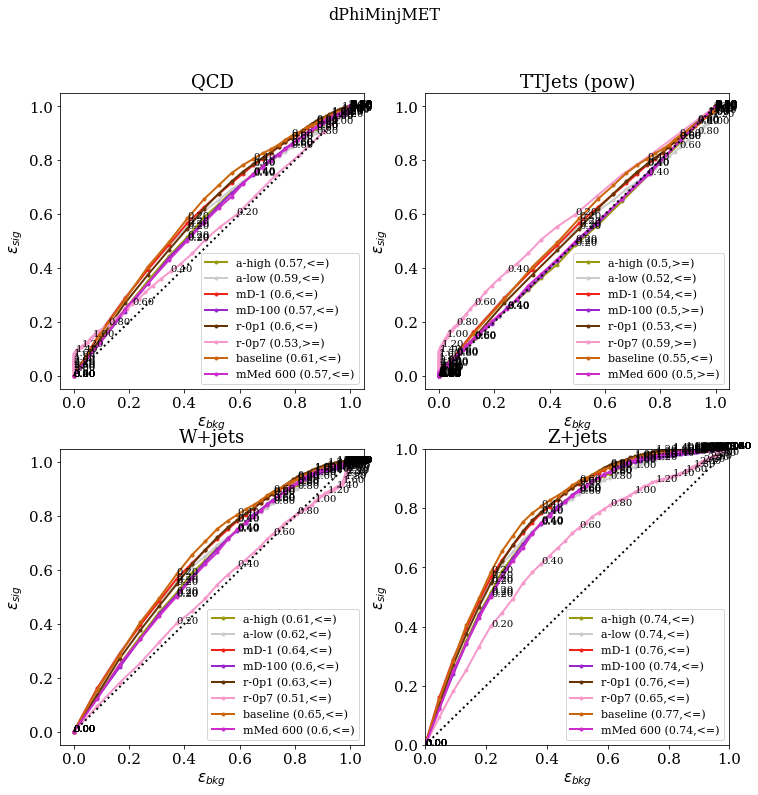

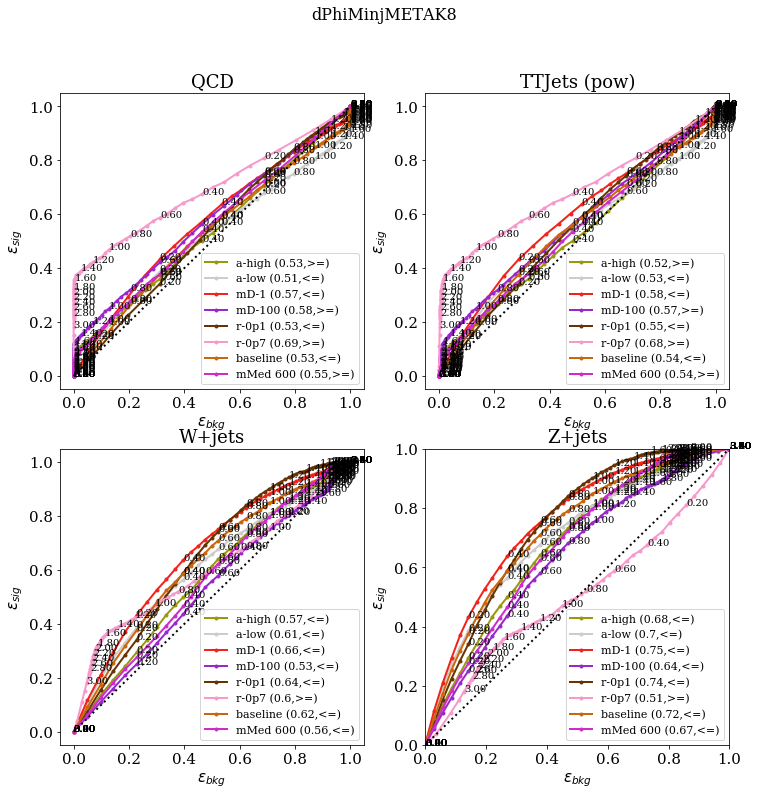

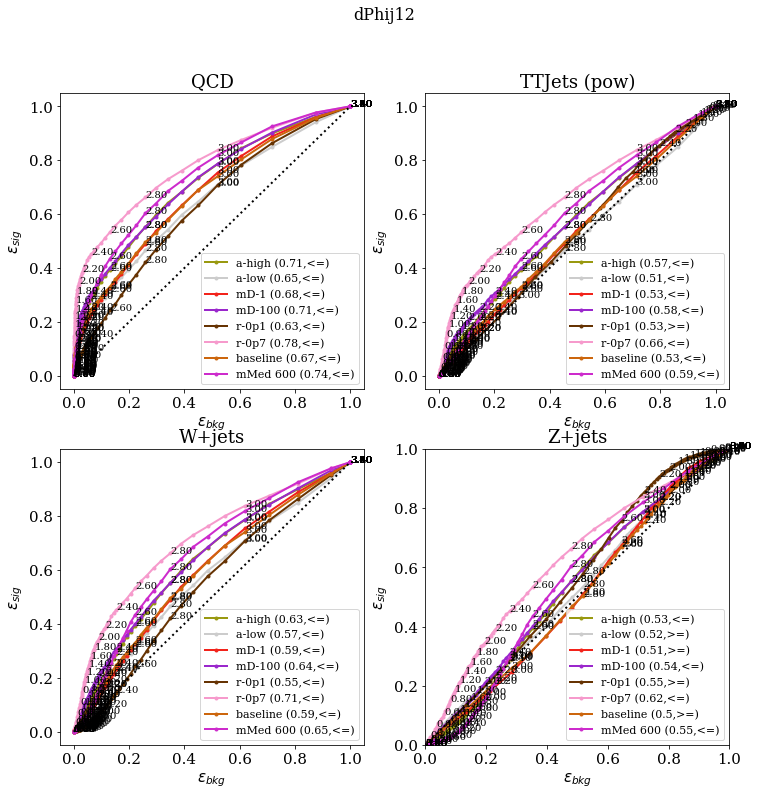

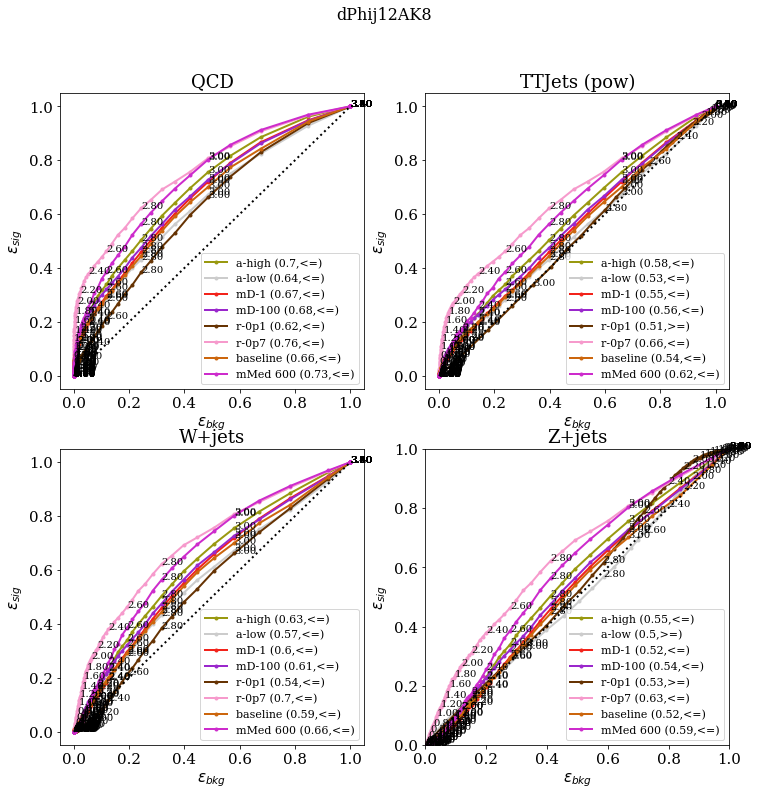

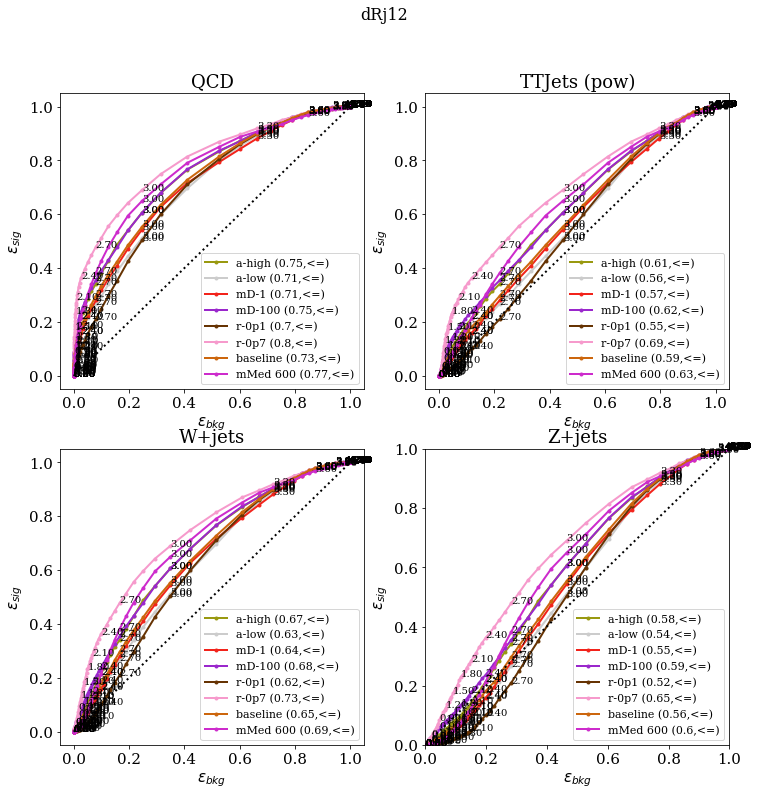

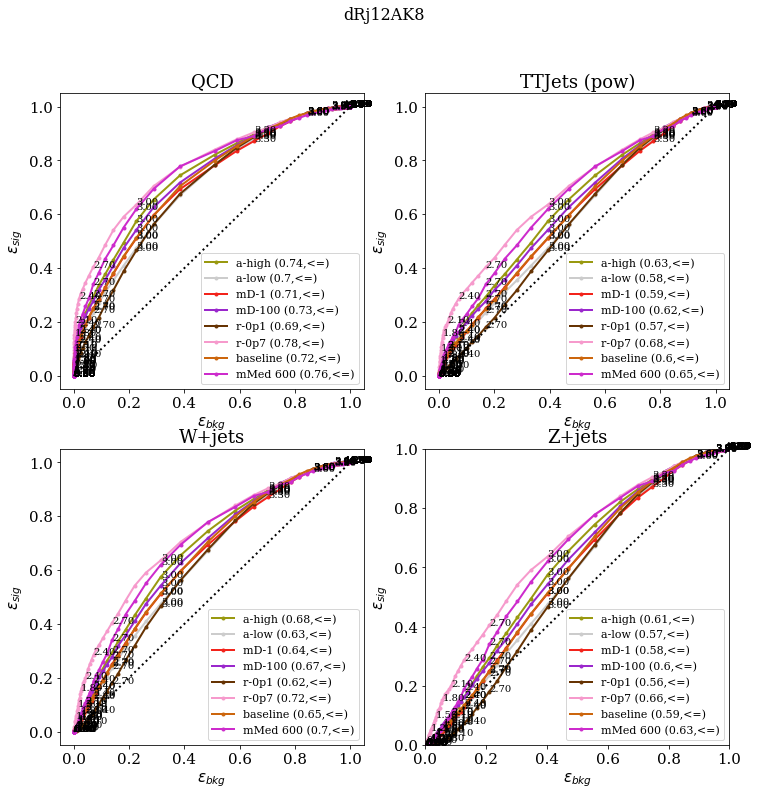

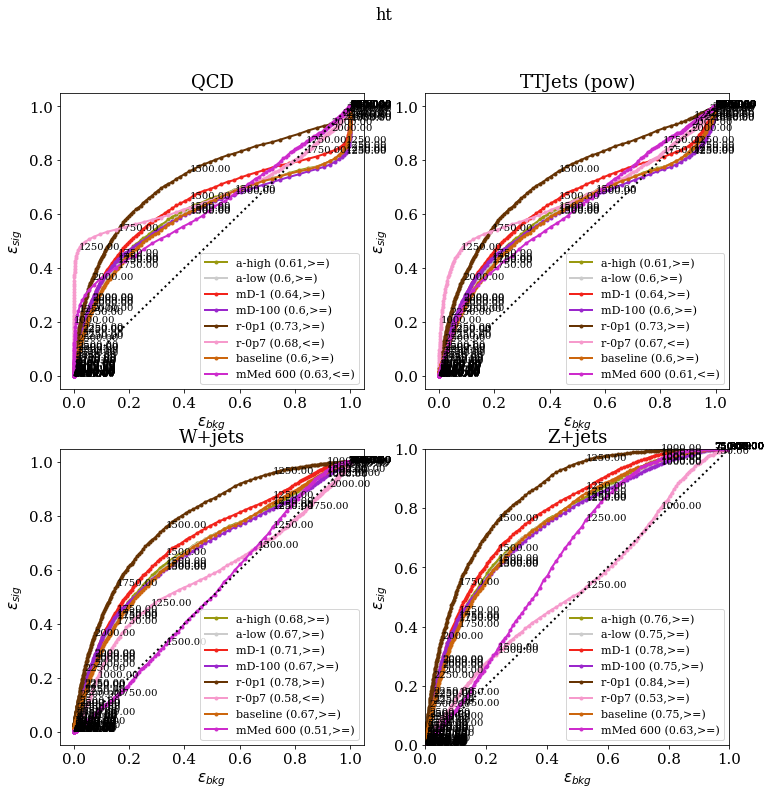

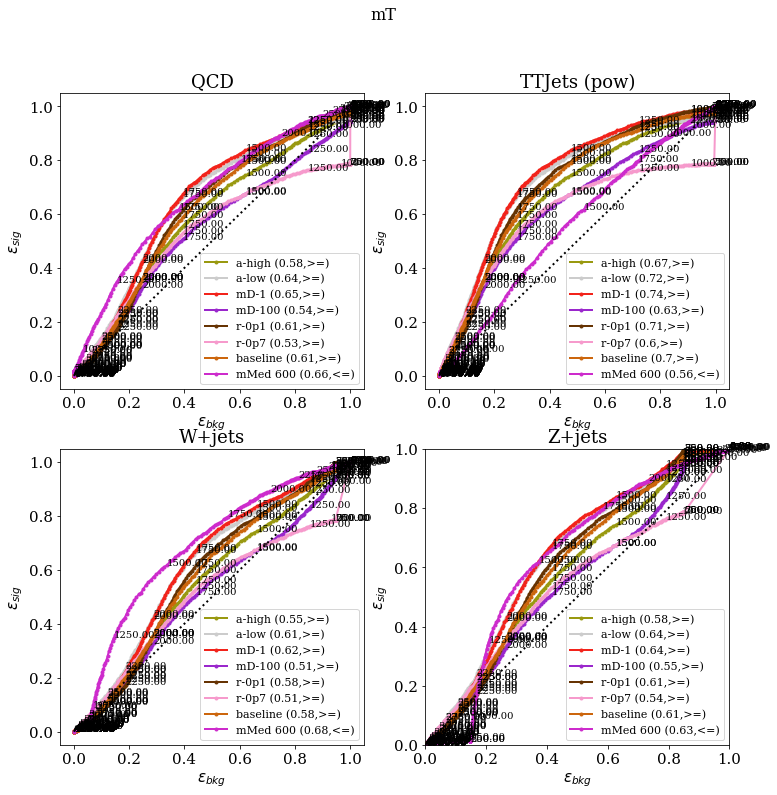

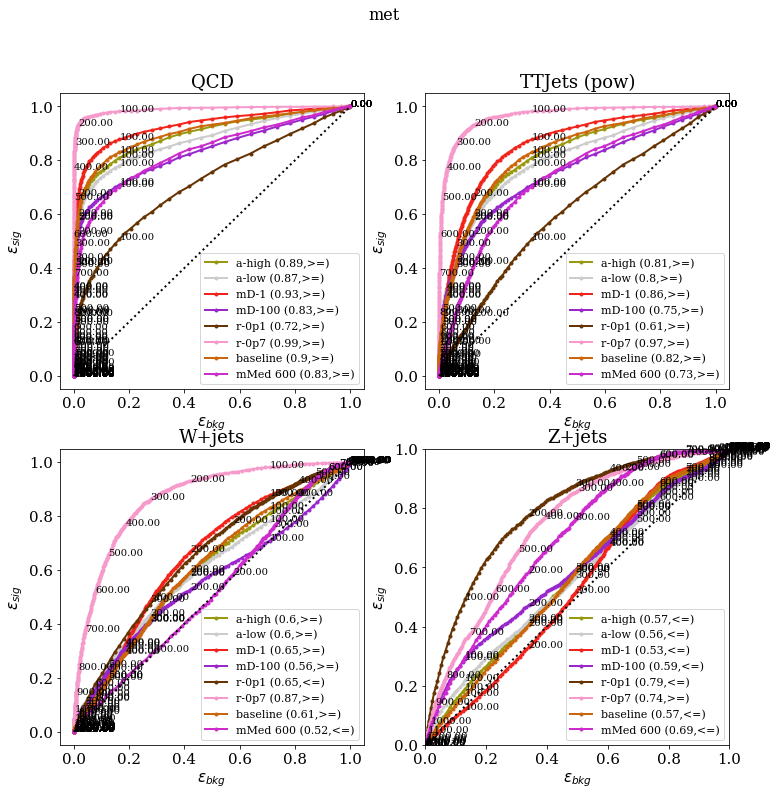

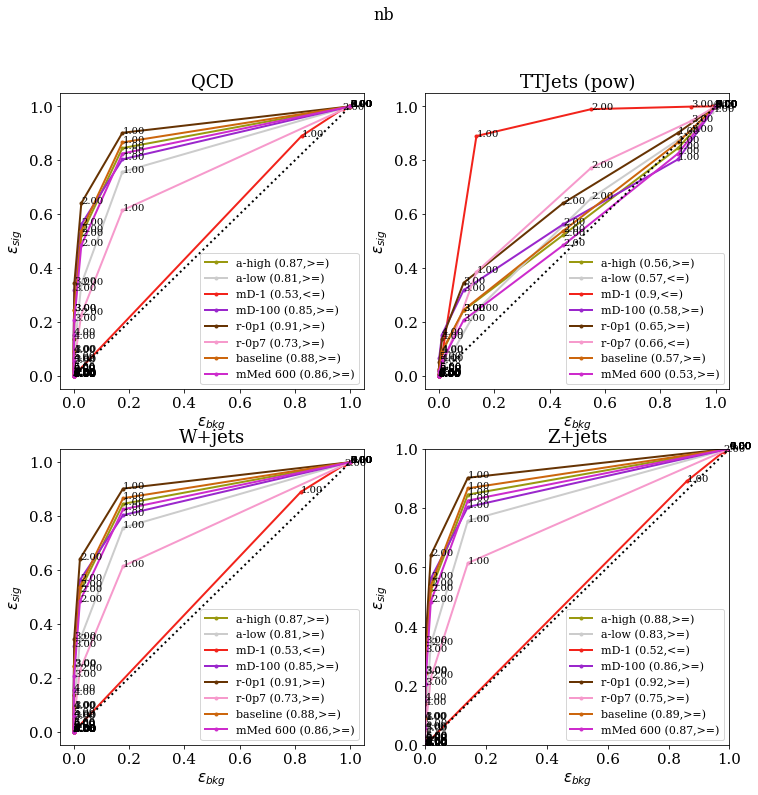

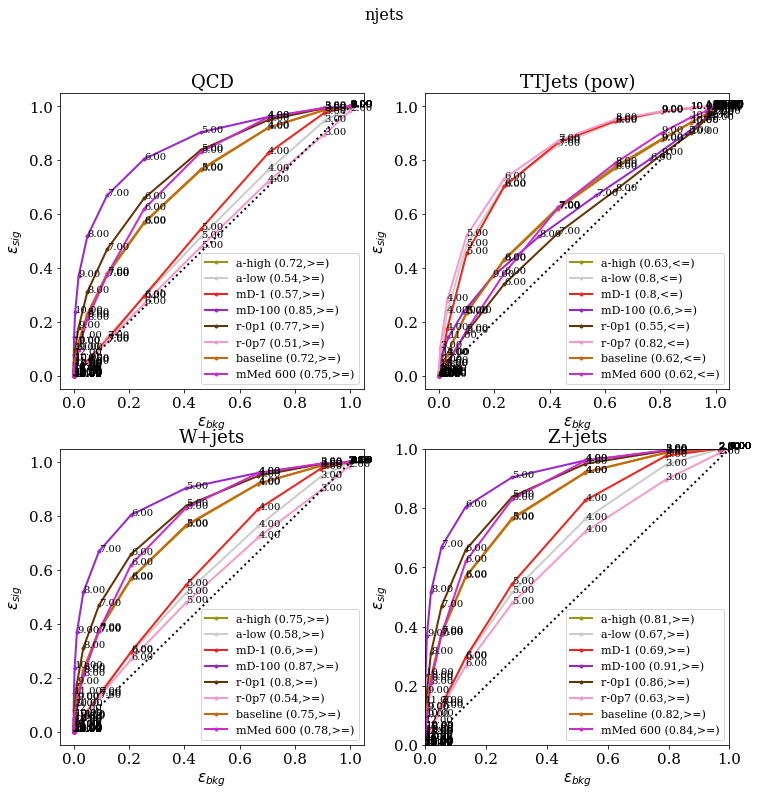

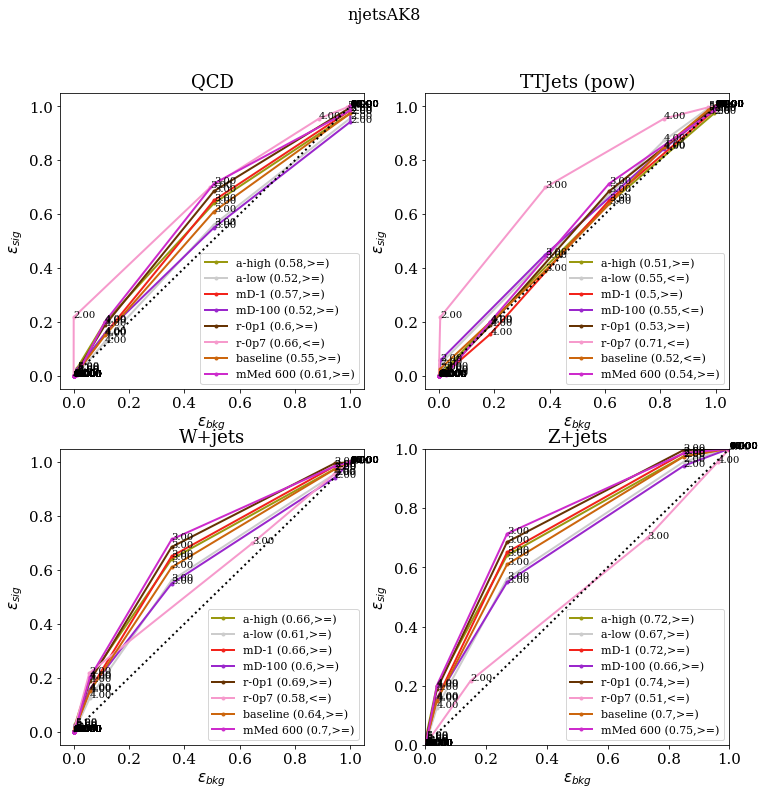

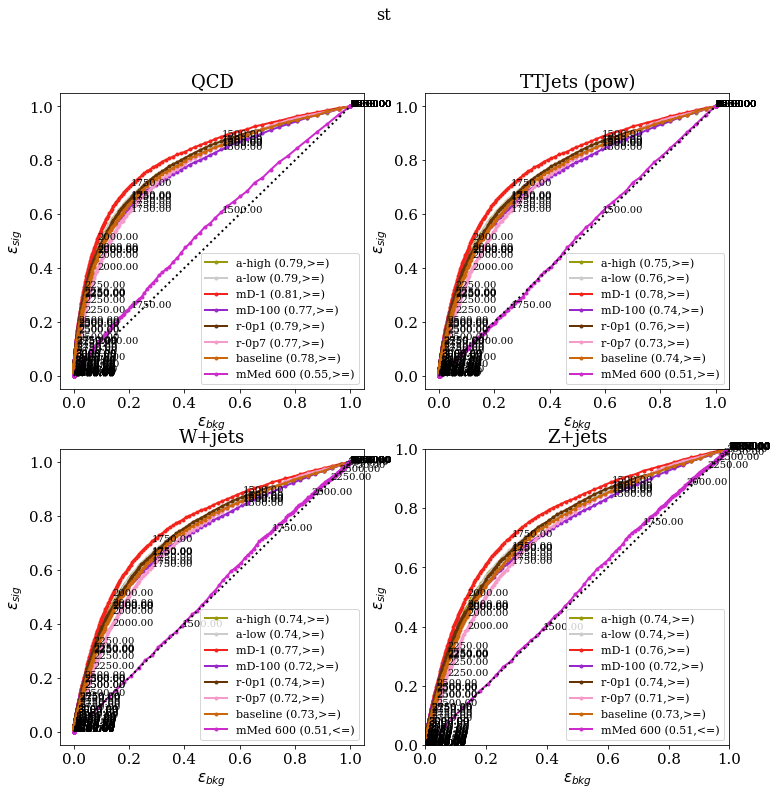

In [71]:
performStudy("UL_jetalt2p4_trigger_qual_FlorianCuts_2018_morejN_count")

# Round 2

/home/keane/anaconda3/lib/python3.7/site-packages/pandas/core/missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


dPhiMinjMET
['METrHT_pt30', 'METrST_pt30', 'dPhij12', 'dPhij23AK8', 'dRj12', 'dRj12AK8', 'ht', 'mT', 'met', 'nb', 'njets', 'st']


bkg                var  counts           bkg                var  counts  \
0   QCD                met       8  TTJets (pow)        METrHT_pt30     7.0   
1   QCD           dRj12AK8       8  TTJets (pow)            j1PtAK8     7.0   
2   QCD              dRj12       8  TTJets (pow)                met     7.0   
3   QCD        METrHT_pt30       7  TTJets (pow)        METrST_pt30     7.0   
4   QCD         dPhij23AK8       7  TTJets (pow)                 st     7.0   
5   QCD                 nb       7  TTJets (pow)         j2Tau21AK8     6.0   
6   QCD          j2Tau3AK8       7  TTJets (pow)        j4Axisminor     6.0   
7   QCD          j2Tau2AK8       7  TTJets (pow)               j1Pt     6.0   
8   QCD        METrST_pt30       7  TTJets (pow)        j4Axismajor     6.0   
9   QCD     j2AxisminorAK8       7  TTJets (pow)        j3Axismajor     5.0   
10  QCD                 st       7  TTJets (pow)                 mT     5.0   
11  QCD        j2Axisminor       6  TTJets (pow)        j3Axisminor     4.0   
12  QCD              njets       5  TTJets (pow)              njets     3.0   
13  QCD          j2Tau1AK8       5  TTJets (pow)  j2SoftDropMassAK8     3.0   
14  QCD         j2GirthAK8       5  TTJets (pow)     j1AxismajorAK8     3.0   
15  QCD            dPhij12       5  TTJets (pow)         j1GirthAK8     3.0   
16  QCD            j1PtAK8       5  TTJets (pow)          j1Tau2AK8     2.0   
17  QCD        j2Axismajor       4  TTJets (pow)     j1AxisminorAK8     2.0   
18  QCD         dPhij12AK8       4  TTJets (pow)          j1Tau1AK8     2.0   
19  QCD     j2AxismajorAK8       4  TTJets (pow)     j2AxismajorAK8     2.0   
20  QCD          j3Tau2AK8       3  TTJets (pow)         j1Tau21AK8     2.0   
21  QCD  j2SoftDropMassAK8       3  TTJets (pow)          j2Tau3AK8     2.0   
22  QCD               j2Pt       3  TTJets (pow)          j2Tau1AK8     2.0   
23  QCD           j2PtDAK8       3  TTJets (pow)                 nb     2.0   
24  QCD           dRj13AK8       3  TTJets (pow)               j2Pt     2.0   

       bkg                var  counts     bkg                var  counts  
0   W+jets          j2Tau2AK8     7.0  Z+jets                 st     7.0  
1   W+jets        j2Axisminor     7.0  Z+jets     j2AxisminorAK8     7.0  
2   W+jets                 nb     7.0  Z+jets                 nb     7.0  
3   W+jets          j2Tau3AK8     7.0  Z+jets          j2Tau3AK8     7.0  
4   W+jets           j2PtDAK8     7.0  Z+jets          j2Tau2AK8     7.0  
5   W+jets     j2AxisminorAK8     7.0  Z+jets                 ht     6.0  
6   W+jets                 st     7.0  Z+jets              njets     5.0  
7   W+jets                 ht     6.0  Z+jets         j2GirthAK8     5.0  
8   W+jets              njets     5.0  Z+jets              dRj12     5.0  
9   W+jets              j2PtD     5.0  Z+jets           dRj12AK8     5.0  
10  W+jets        j2Axismajor     4.0  Z+jets          j2Tau1AK8     5.0  
11  W+jets          j4Tau2AK8     4.0  Z+jets            j1PtAK8     4.0  
12  W+jets     j4AxisminorAK8     4.0  Z+jets           j2PtDAK8     4.0  
13  W+jets          j3Tau2AK8     4.0  Z+jets        j2Axismajor     4.0  
14  W+jets          j2Tau1AK8     4.0  Z+jets     j2AxismajorAK8     4.0  
15  W+jets              dRj12     4.0  Z+jets            dPhij12     4.0  
16  W+jets           dRj12AK8     4.0  Z+jets           njetsAK8     3.0  
17  W+jets     j3AxisminorAK8     4.0  Z+jets        j2Axisminor     3.0  
18  W+jets     j2AxismajorAK8     3.0  Z+jets               j3Pt     3.0  
19  W+jets          j4Tau3AK8     3.0  Z+jets  j2SoftDropMassAK8     3.0  
20  W+jets  j3SoftDropMassAK8     3.0  Z+jets        METrHT_pt30     2.0  
21  W+jets            j1PtAK8     3.0  Z+jets         dPhij12AK8     2.0  
22  W+jets          j3Tau3AK8     3.0  Z+jets          j3Tau2AK8     2.0  
23  W+jets  j2SoftDropMassAK8     3.0  Z+jets               j4Pt     2.0  
24  W+jets         j2GirthAK8     3.0  Z+jets                met     2.0

Suggested cuts:
METrHT_pt30 >= 0.03
METrST_pt30 >= 0.03
dPhij12 <= 3.08
dPhij23AK8 >= 0.72
dRj12 <= 3.1799999999999997
dRj12AK8 <= 3.2399999999999998
ht >= 1210.0
mT >= 1284.0
met >= 60.0
nb >= 1.0
njets >= 4.0
st >= 1420.0


FileNotFoundError: [Errno 2] No such file or directory: 'preStudy_betterxrange_run2/yieldValues.pkl'

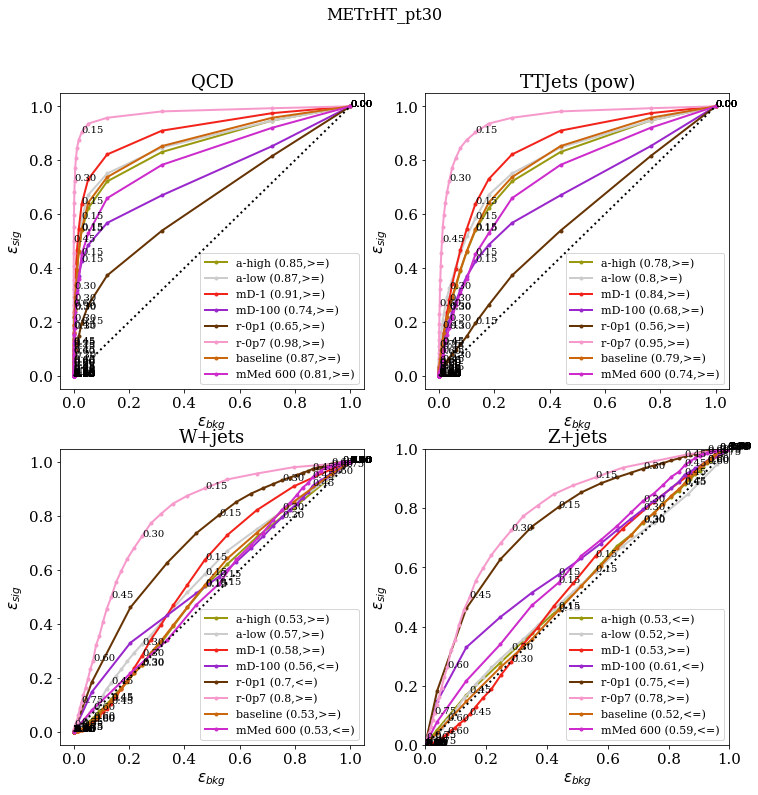

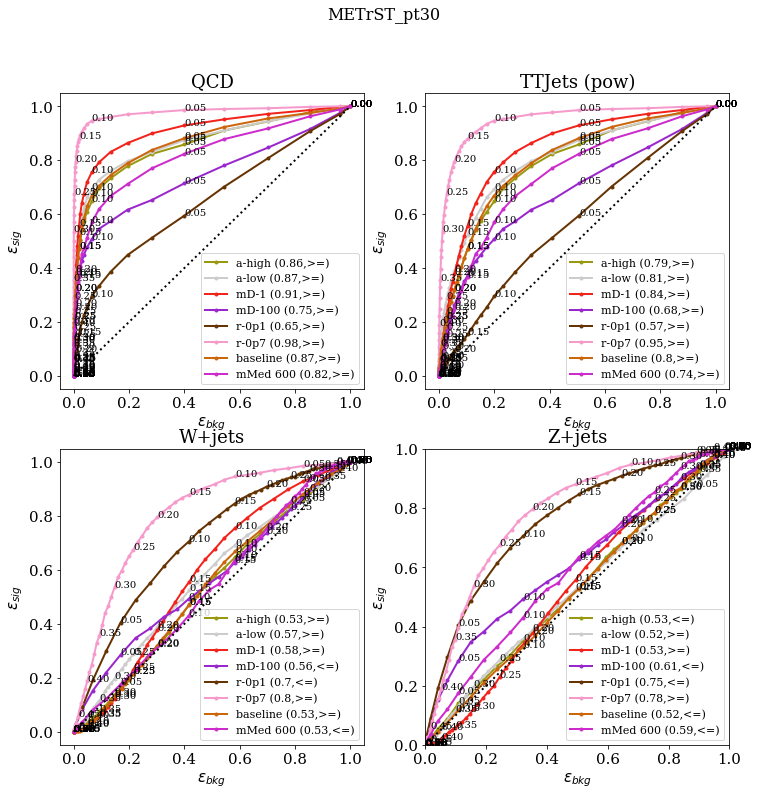

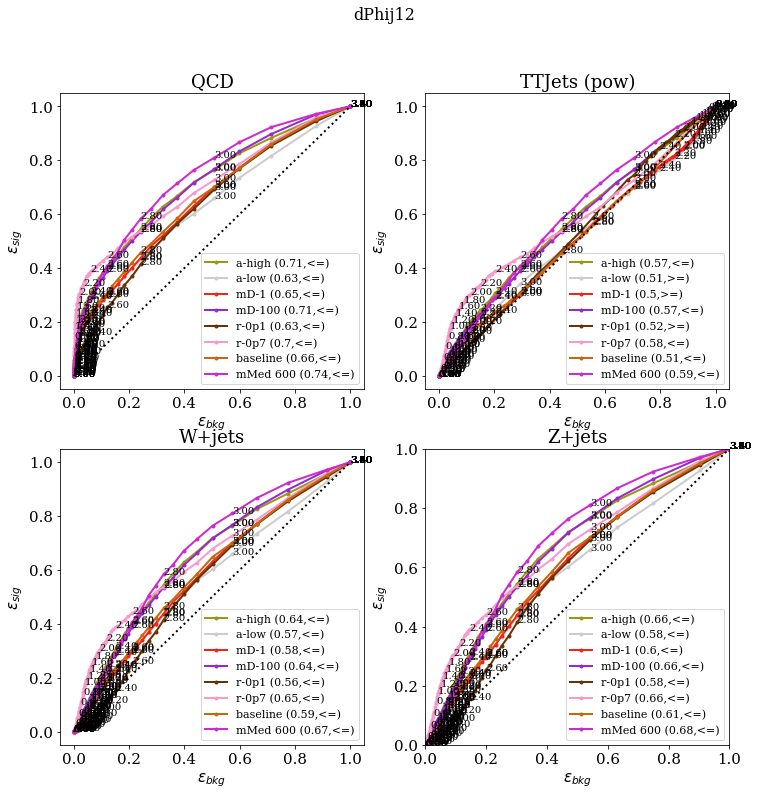

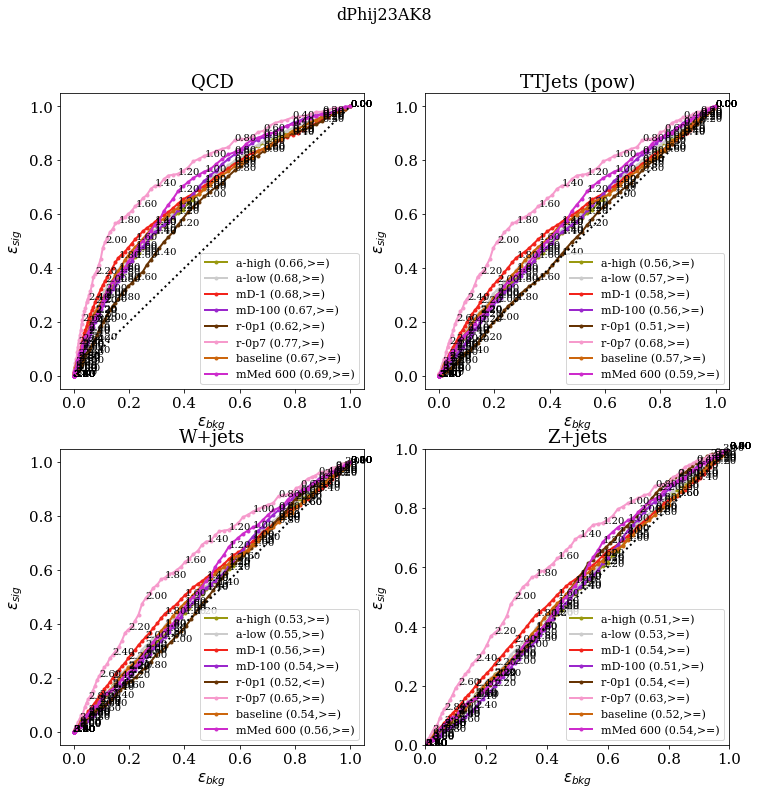

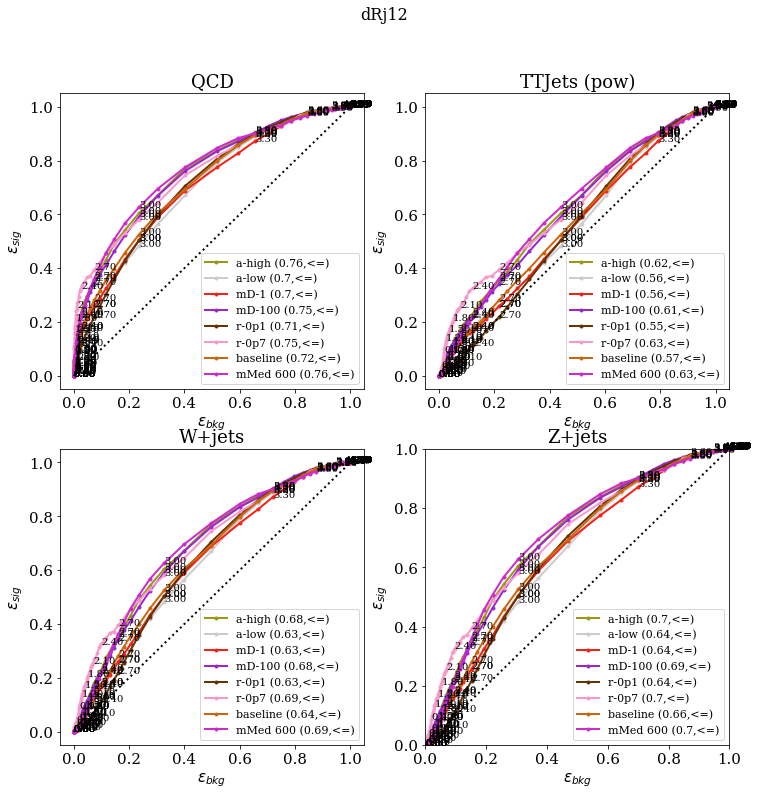

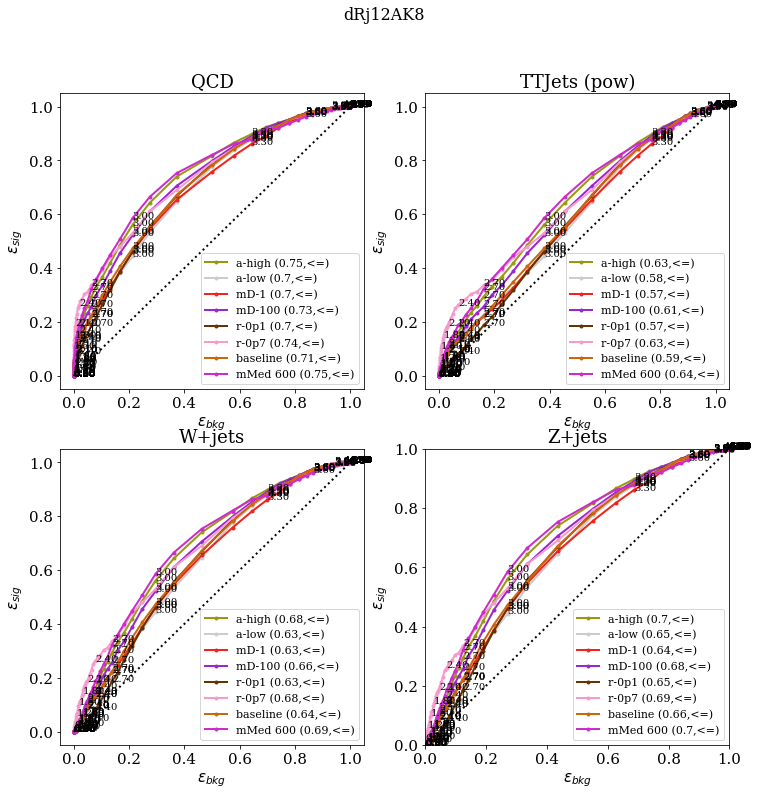

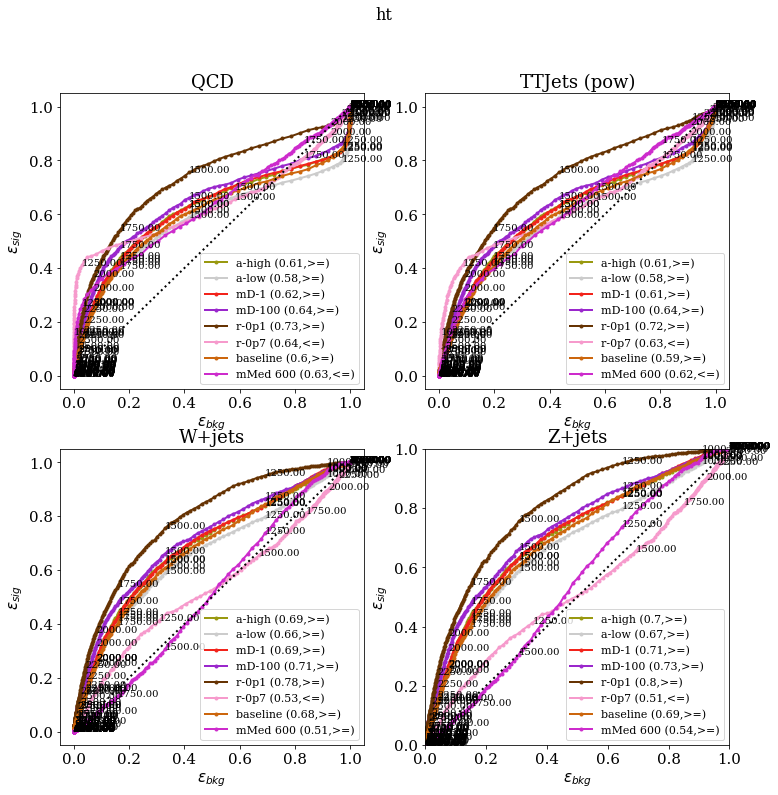

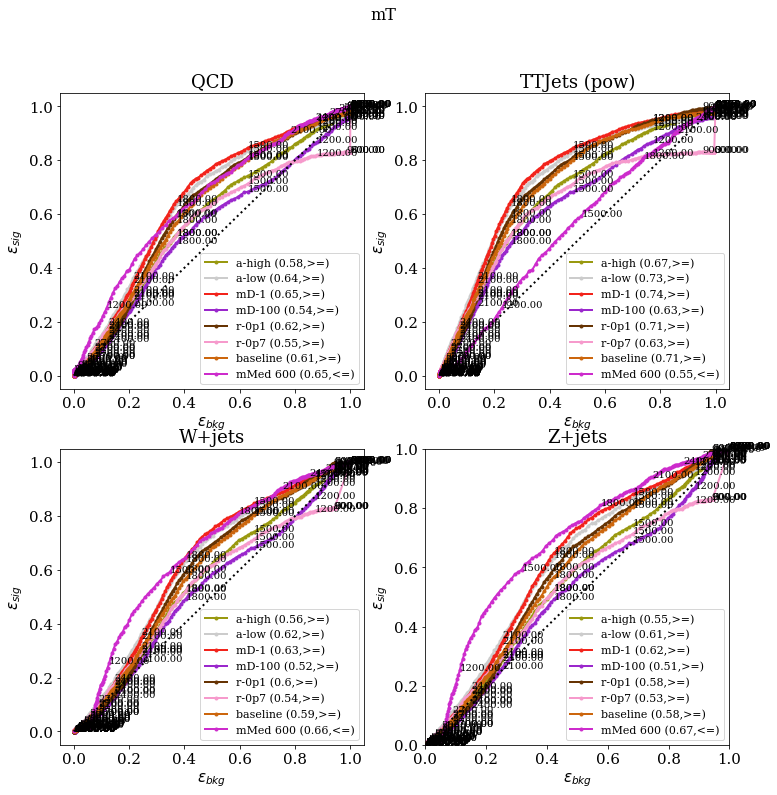

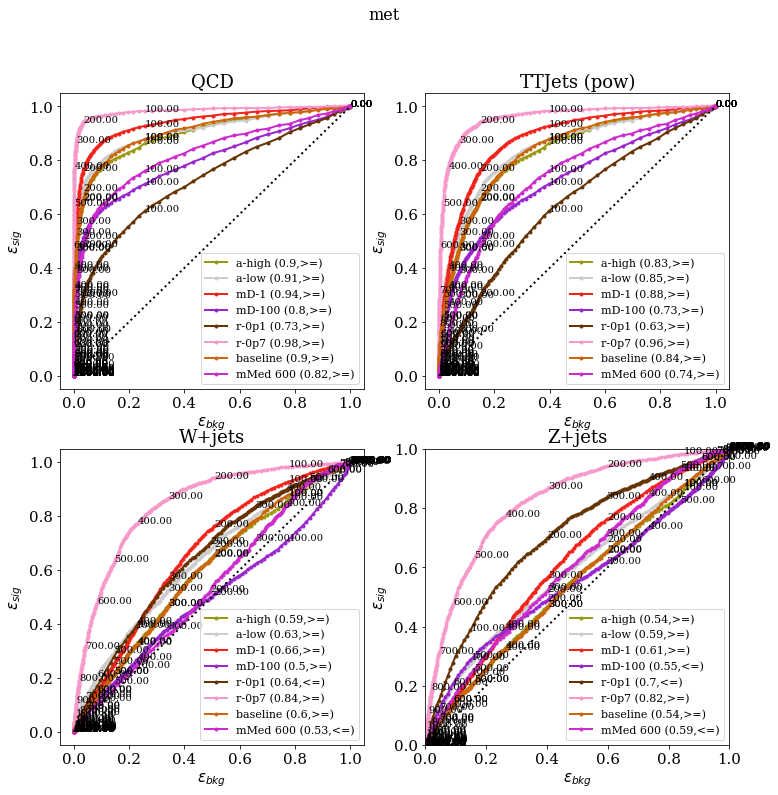

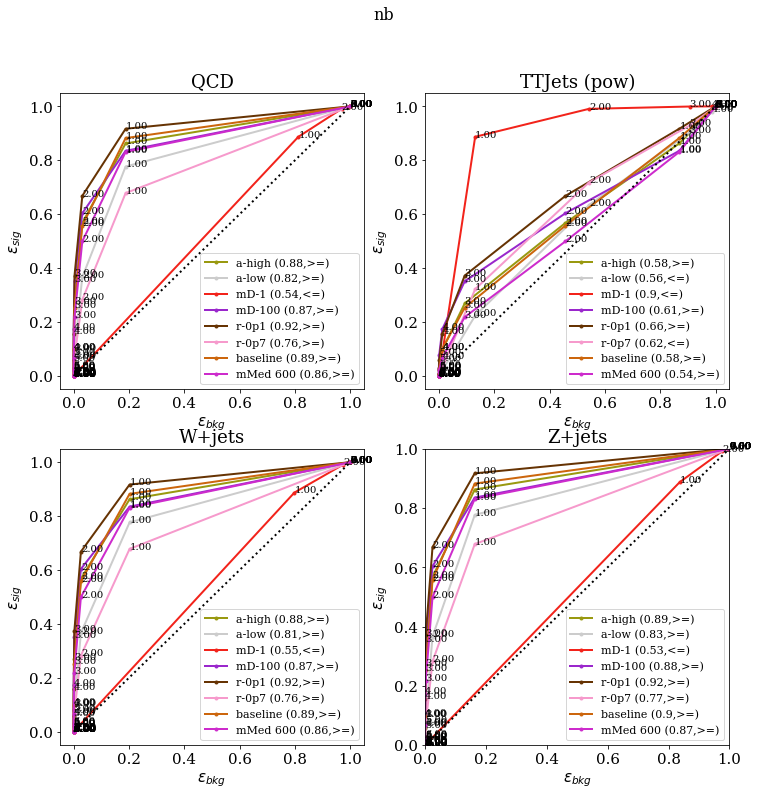

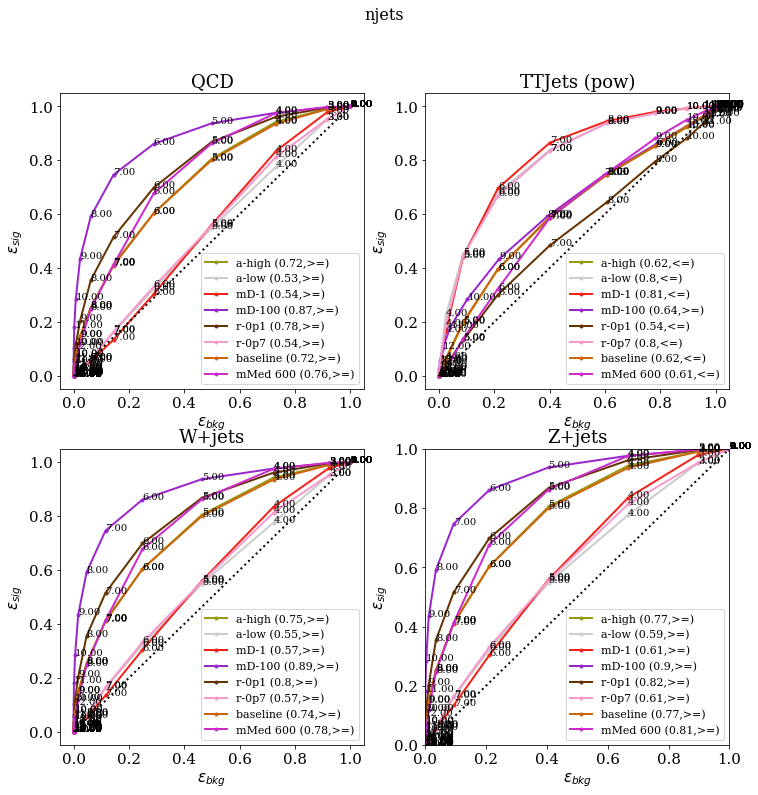

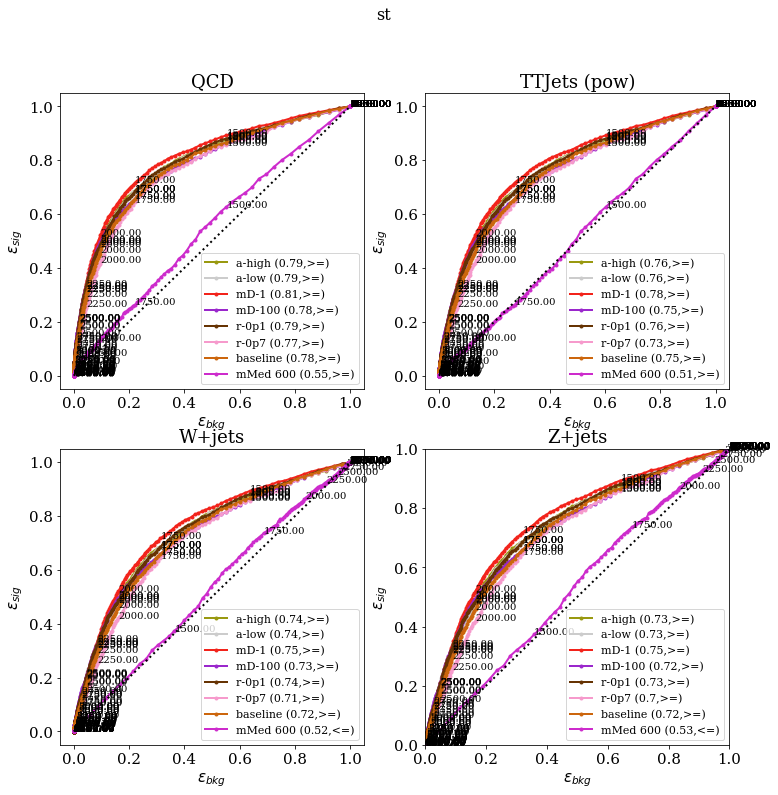

In [63]:
performStudy("preStudy_betterxrange_run2")